### This example notebook is used to perform molecular anatomical parcellation
- Step 1: PCA analysis to generate eigen images and identify parcellation markers. 
- Step 2: Creat parcellation maps with Gaussian process classifiers

In [1]:
import os, sys
import numpy as np
import pandas as pd
from glob import glob
from scipy import stats,spatial
from scipy.stats import kde
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from skimage.filters import threshold_otsu

#For plotting#
import matplotlib.pyplot as plt
from matplotlib import rcParams,colors
rcParams['axes.labelpad'] = 8
rcParams['pdf.fonttype'] = 42
import seaborn as sns
sns.set(style='ticks', palette='Set2')

### Load data files

In [2]:
cea=pd.read_csv('/nrs/multifish/cea_example_data.csv',sep=',', index_col=0)
print('example dataset shape:',cea.shape)

In [ ]:
cea

### 1. PCA analysis on the gene expression spatial patterns

In [5]:
# z score normalize FISH data and get spatial expression map for each gene

fish=cea.iloc[:,:-2]
fish_z=stats.zscore(fish)
fish_z=pd.DataFrame(data=fish_z, columns=fish.columns, index=fish.index)

radius=50
A=cea.iloc[:, -2:].to_numpy()[:,[1,0]]
a = np.arange(cea.x.min(), cea.x.max(), 10)  
b = np.arange(cea.y.min(), cea.y.max(), 10)
xa, xb = np.meshgrid(a, b) 
U=np.zeros((xa.flatten().shape[0],2))
U[:,0] = xa.flatten()
U[:,1] = xb.flatten()

X=spatial.KDTree(A.astype(np.float64))
neuron=spatial.KDTree(U)
neighbors=X.query_ball_point(U,radius)

expression=np.empty([len(U),len(fish.columns)])
index=0
for g in fish.columns:    
    gene=str(g)
    ind1=fish.columns.get_loc(gene)
    for i in range(0,len(neighbors)):
        x=[]
        for j in neighbors[i]:
            x=np.append(x, fish_z.iloc[j,ind1])
        if len(x)==0:
            expression[i,index]=0
        else:
            expression[i,index]=x.mean()
    index+=1  
matrix=pd.DataFrame(data=expression,columns=fish.columns)
matrix=matrix.T

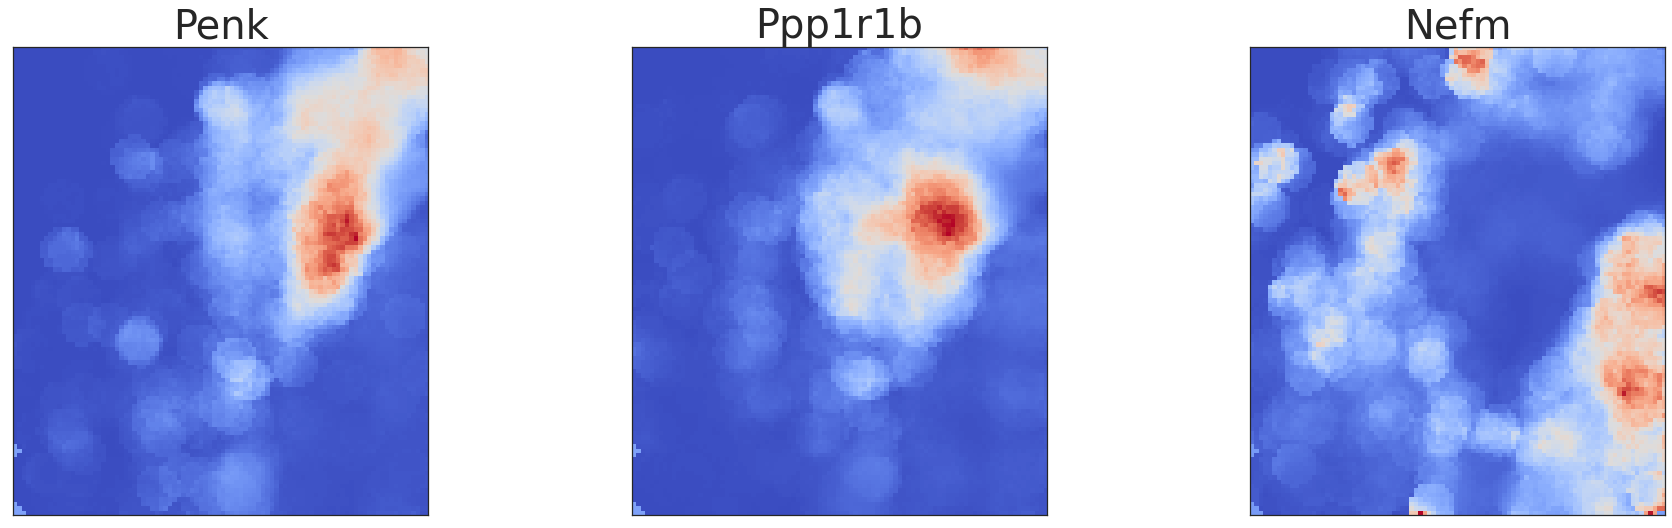

In [6]:
# Examine the spatial gene expression patterns

markers=['Penk','Ppp1r1b','Nefm']
fig, ax = plt.subplots(1,len(markers), figsize=(27,7.5))

# fig, ax = plt.subplots(20,3,figsize=(20,150),dpi=50)
i=0
for g in markers:
    ax[i].imshow(matrix.loc[g].to_numpy().reshape(xa.shape),
                 cmap=plt.cm.coolwarm,rasterized=True)
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])
    ax[i].xaxis.set_ticks([])
    ax[i].yaxis.set_ticks([])
    ax[i].set_title(g,fontsize=40)
    i+=1
plt.tight_layout()

In [7]:
#Run PCA analysis
pca = PCA(n_components=4,whiten=True,random_state=2)
matlab_equi_score = pca.fit_transform(matrix)

<Figure size 432x288 with 0 Axes>

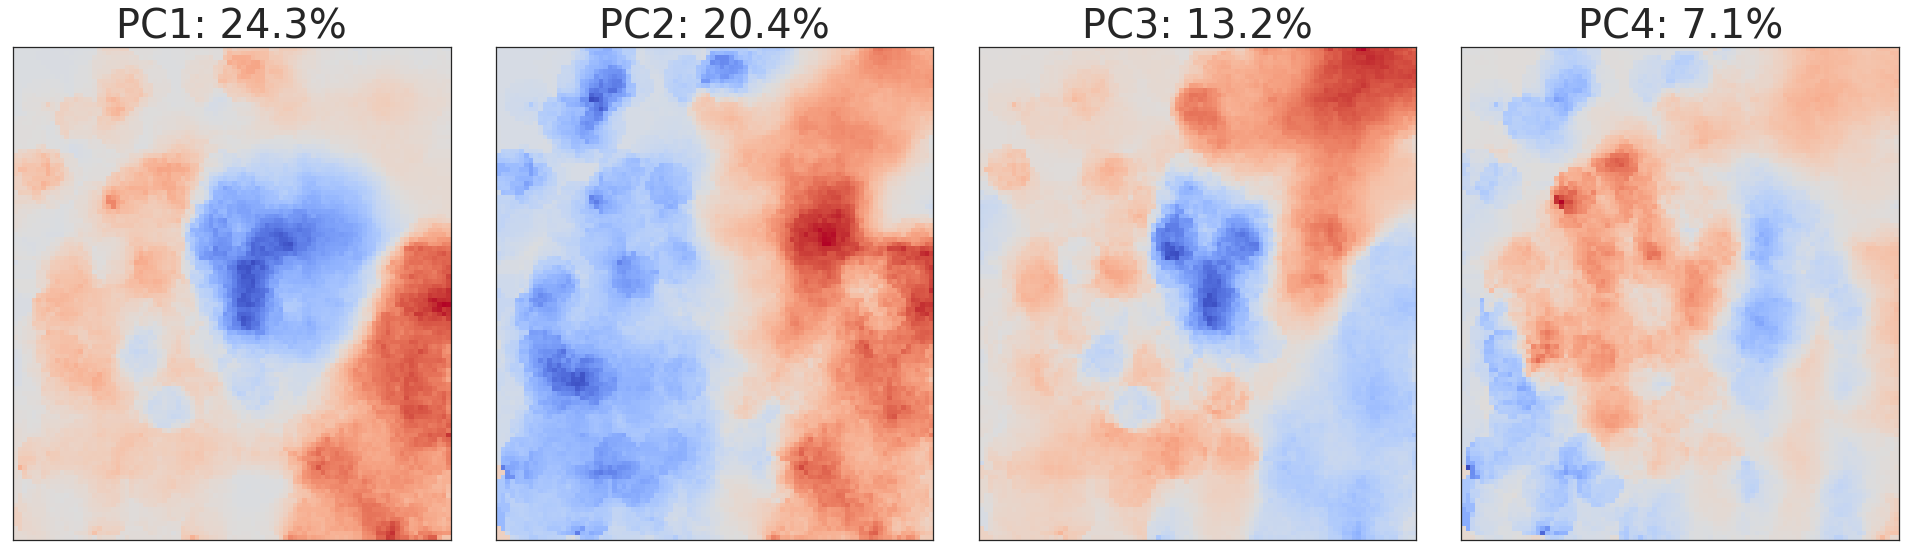

In [8]:
# Plot eigen images

n=4
plt.figure()
fig, ax = plt.subplots(1,n, figsize=(27,7.5))

# fig, ax = plt.subplots(20,3,figsize=(20,150),dpi=50)

for i in range(0,n):
    ax[i].imshow(pca.components_[i].reshape(xa.shape),
                 cmap=plt.cm.coolwarm,rasterized=True)
    
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])
    ax[i].xaxis.set_ticks([])
    ax[i].yaxis.set_ticks([])
    ax[i].set_title("PC"+str(i+1)+": "+"{:0.1f}".format(pca.explained_variance_ratio_[i]*100)+"%",fontsize=40)
plt.tight_layout()


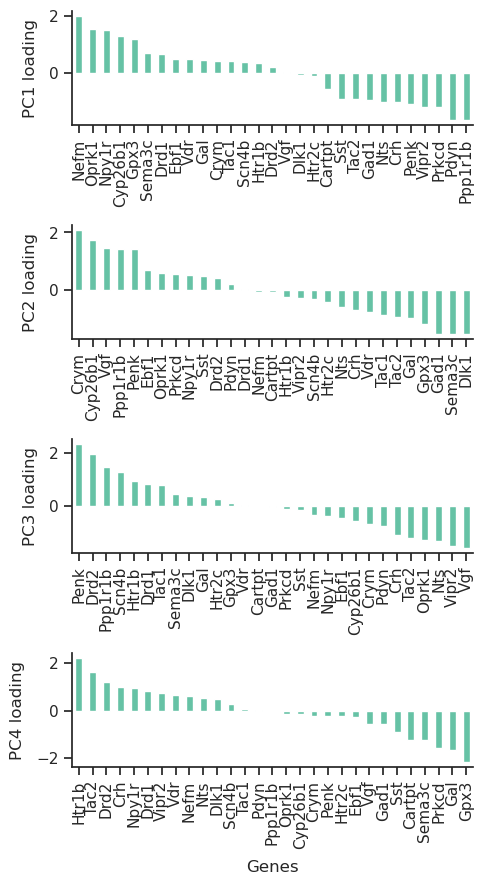

In [9]:
# Plot the loadings of each gene on selected PCs
x=pd.DataFrame(matlab_equi_score,index=matrix.index)
fig, ax = plt.subplots(4,1,figsize=(5,9),dpi=100,sharex=False) 

x[0].sort_values(ascending=False).plot(kind='bar',sharex=False,ax=ax[0],ylabel='PC1 loading')
x[1].sort_values(ascending=False).plot(kind='bar',sharex=False,ax=ax[1],ylabel='PC2 loading')
x[2].sort_values(ascending=False).plot(kind='bar',sharex=False,ax=ax[2],ylabel='PC3 loading')
x[3].sort_values(ascending=False).plot(kind='bar',sharex=False,ax=ax[3],ylabel='PC4 loading')

plt.xlabel('Genes',size=12)
# plt.ylabel('PCs',size=12)
sns.despine()
plt.tight_layout()

### 2. Parcellation with selected marker genes (here we used Ppp1r1b, Penk and Nefm)

In [10]:
# threshold marker gene expression using otsu
cea.loc[:,'class']=4
A=cea[cea['Ppp1r1b']>threshold_otsu(cea['Ppp1r1b'])]
cea.loc[A.index,'class']=0
B=cea[cea['Penk']>threshold_otsu(cea['Penk'])]
cea.loc[B.index,'class']=1
C=cea[cea['Nefm']>threshold_otsu(cea['Nefm'])]
cea.loc[C.index,'class']=2

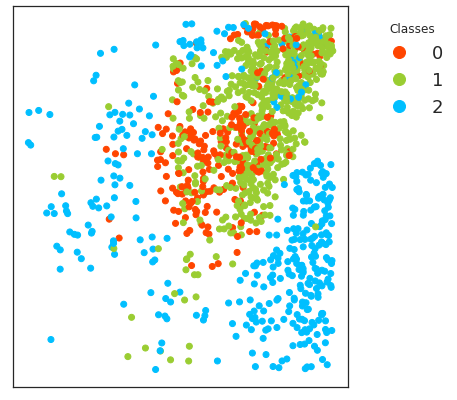

In [11]:
A=cea[cea['class']!=4]
newcmp = colors.ListedColormap(['orangered','yellowgreen','deepskyblue'])
norm = colors.BoundaryNorm([0, 1, 2, 3], newcmp.N)

fig,ax = plt.subplots(1,1,figsize=(6, 7))
a=ax.scatter(A.x, A.y, c=A['class'], cmap=newcmp,rasterized=True)
ax.set_xticks(())
ax.set_yticks(())
ax.invert_yaxis()
legend1 = ax.legend(*a.legend_elements(),
                    title="Classes",fontsize=18,
                    markerscale=2,bbox_to_anchor=(1.05, 1.0), 
                    loc='upper left',frameon=False)

In [12]:
#Set up using Gaussian process classifier to generate the parcellation map

classifier = GaussianProcessClassifier(kernel= 1.0 * RBF([1.0, 1.0]))
i = 1
A=cea.iloc[:,-3:-1].to_numpy()[:,[1,0]]
X = cea[cea['class']!=4].iloc[:,-3:-1].to_numpy()[:,[1,0]]
y = cea[cea['class']!=4]['class'].to_numpy().astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)
h=1 #step size in the mesh
x_min, x_max = A[:, 0].min(), A[:, 0].max()
y_min, y_max = A[:, 1].min(), A[:, 1].max()
xx, yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

<Figure size 648x648 with 0 Axes>

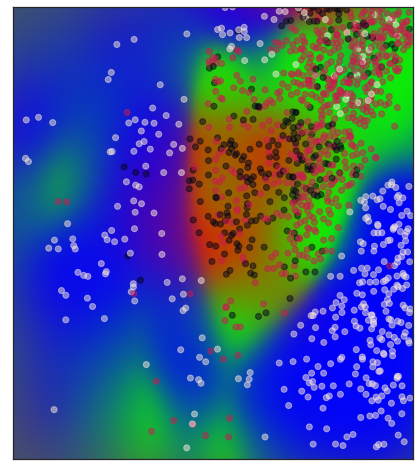

In [13]:
figure = plt.figure(figsize=(9, 9))
i=1

fig,ax = plt.subplots(1,1,figsize=(6, 7))
classifier.fit(X,y)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
ax.imshow(Z, extent=(x_min, x_max, y_min, y_max),origin='lower')

# Plot the training points
ax.scatter(
    X[:, 0], X[:, 1], c=y, alpha=0.5,
)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.invert_yaxis()

plt.tight_layout()
plt.show()